In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import brier_score_loss 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import log_loss 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
import seaborn as sns 
import matplotlib.pyplot as plt 

In [3]:
pd.set_option("display.max_columns", None)
df = pd.read_csv('../data/modeling/reg_season_ml.csv')
df.shape

(125184, 113)

# Logistic Regression 

In [ ]:
x = df.drop(columns=['Season', 'DayNum', 'Team1', 'Team2', 'Team1_Wins', 
                    'Conf_pac_ten_1', 'Conf_pac_ten_2', 'Conf_gwc_1', 'Conf_gwc_2', 'Conf_mid_cont_1', 'Conf_mid_cont_2'])
y = df['Team1_Wins']

# Train the model 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=57)

# Normalize the data 
scaler = StandardScaler()

# Fit on training data and transform both train & test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Logistic Regression model
logreg = LogisticRegression(C=100)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(C=100)

### Feature Engineering

**Analyze which features are the most important**

In [5]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns, 
    'Importance': logreg.coef_[0]
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=True)
feature_importance

,Feature,Importance
50,Win_Percentage_2,-0.895245
99,srs_rating_2,-0.628318
73,Conf_big_twelve_2,-0.289564
72,Conf_big_ten_2,-0.281489
44,Conf_swac_1,-0.264444
...,...,...
94,Conf_swac_2,0.264070
22,Conf_big_ten_1,0.277791
23,Conf_big_twelve_1,0.286746
49,srs_rating_1,0.618289


**Identify which features are highly correlated and can be removed**

In [7]:
corr_matrix = X_train.corr().abs() 
# Select upper triangle of correlation matrix (to avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find features with correlation > 0.9
high_correlation = [(column, index) for column in upper.columns for index in upper.index if upper[column][index] > 0.9]

# Print correlated feature pairs
for f1, f2 in high_correlation:
    print(f"High correlation: {f1} <--> {f2} (r = {corr_matrix.loc[f1, f2]:.2f})")

High correlation: srs_rating_1 <--> Win_Percentage_1 (r = 0.91)
High correlation: srs_rating_2 <--> Win_Percentage_2 (r = 0.91)


### Model Evaluation

Brier Score: 0.1645
Accuracy: 0.7504
Log Loss: 0.4929
ROC-AUC Score: 0.8377


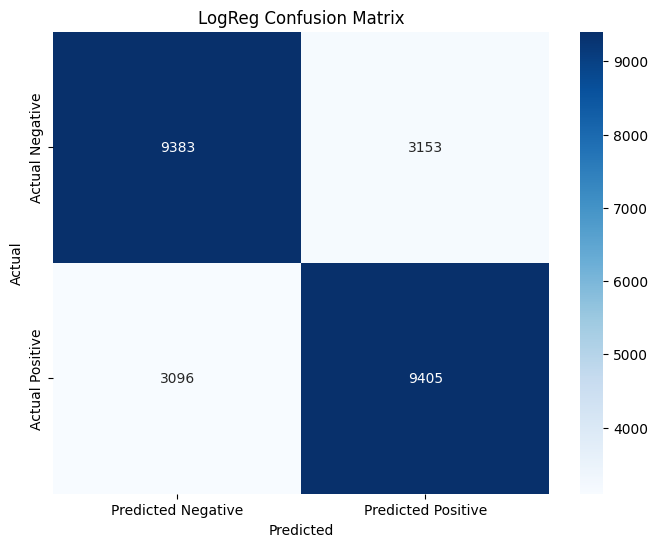

In [8]:
# Make predictions on the test set
y_pred = logreg.predict(X_test_scaled)
y_pred_probs = logreg.predict_proba(X_test_scaled)[:, 1]

brier = brier_score_loss(y_test, y_pred_probs)
print(f'Brier Score: {brier:.4f}')

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

logloss = log_loss(y_test, y_pred_probs)
print(f'Log Loss: {logloss:.4f}')

auc = roc_auc_score(y_test, y_pred_probs)
print(f'ROC-AUC Score: {auc:.4f}')

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LogReg Confusion Matrix')
plt.show()

### Outcome 
After analyzing the different solvers I identified that the defaul 'lbfgs' performed the best and worked well with the large feature set. It is also noted that setting C to 100 to implement a weaker regularization improved the model 

**Feature Importance** 

Features that were found to have minimal impact on the model include: 
  - **Conf_pac_10**: Conference rebranded to the Pac 12 with the addition of Colorado and Utah 
  - **Conf_gwc**: Great Western Conference became defunct in 2014
  - **Conf_mid_cont**: Mid Continental conference rebranded to the summit league in 2007

**Feature Correlation** 

Effective FG Percentage and FG Percentage were highly correlated, as expceted. This led me to remove Effective FG Percentage which helped increase the brier score for the model 



# K-Nearest Neighbors (k-NN)

k-NN Brier Score: 0.1852
k-NN Accuracy: 0.7123
k-NN Log Loss: 0.5703
k-NN ROC-AUC Score: 0.7934


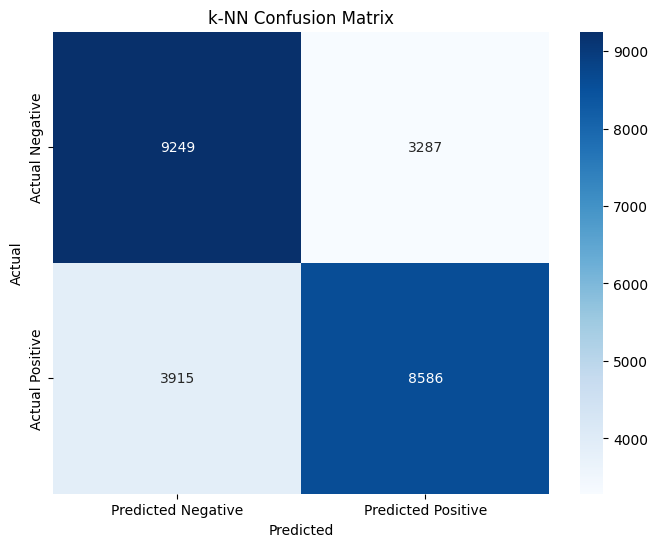

In [37]:
# k-NN model
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_knn = knn.predict(X_test_scaled)
y_pred_probs_knn = knn.predict_proba(X_test_scaled)[:, 1]

# Calculate evaluation metrics
knn_brier = brier_score_loss(y_test, y_pred_probs_knn)
print(f'k-NN Brier Score: {knn_brier:.4f}')

knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f'k-NN Accuracy: {knn_accuracy:.4f}')

knn_logloss = log_loss(y_test, y_pred_probs_knn)
print(f'k-NN Log Loss: {knn_logloss:.4f}')

knn_auc = roc_auc_score(y_test, y_pred_probs_knn)
print(f'k-NN ROC-AUC Score: {knn_auc:.4f}')

# Calculate and display the confusion matrix
knn_conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('k-NN Confusion Matrix')
plt.show()

# Decision Trees

## Boosting - Random Forest 

Random Forest Brier Score: 0.2224
Random Forest Accuracy: 0.6794
Random Forest Log Loss: 0.6749
Random Forest ROC-AUC Score: 0.7366


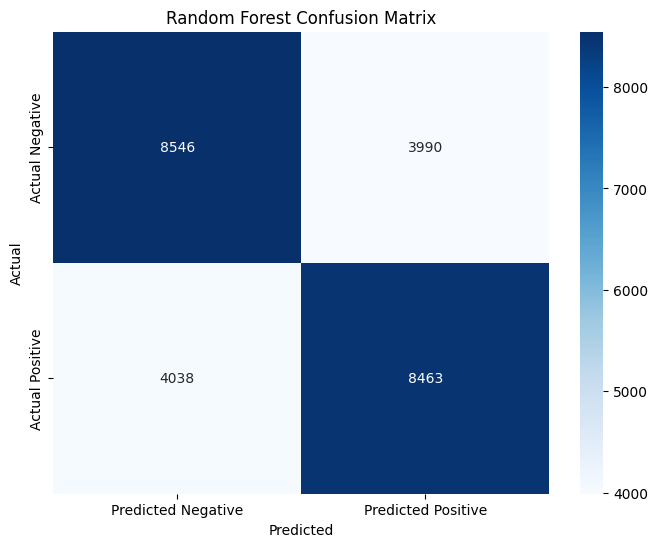

In [38]:
# Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf.predict(X_test)
y_pred_probs_rf = rf.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
rf_brier = brier_score_loss(y_test, y_pred_probs_rf)
print(f'Random Forest Brier Score: {rf_brier:.4f}')

rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')

rf_logloss = log_loss(y_test, y_pred_probs_rf)
print(f'Random Forest Log Loss: {rf_logloss:.4f}')

rf_auc = roc_auc_score(y_test, y_pred_probs_rf)
print(f'Random Forest ROC-AUC Score: {rf_auc:.4f}')

# Calculate and display the confusion matrix
rf_conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()


## Bagging - Extreme Gradient Boosting

In [ ]:
# Define the parameter grid
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': np.arange(3, 10),
    'min_child_weight': np.arange(1, 10),
    'subsample': np.linspace(0.5, 1.0, 5),
    'colsample_bytree': np.linspace(0.5, 1.0, 5)
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss")

# Set up Randomized Search with Brier Score
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=20,  # Number of different parameter combinations to try
    scoring='neg_brier_score',  # Minimizing Brier Score
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)

# Best Brier Score (negated back to positive)
best_brier_score = -random_search.best_score_
print("Best Brier Score:", best_brier_score)

XGBoost Brier Score: 0.1607
XGBoost Accuracy: 0.7570
XGBoost Log Loss: 0.4826
XGBoost ROC-AUC Score: 0.8453


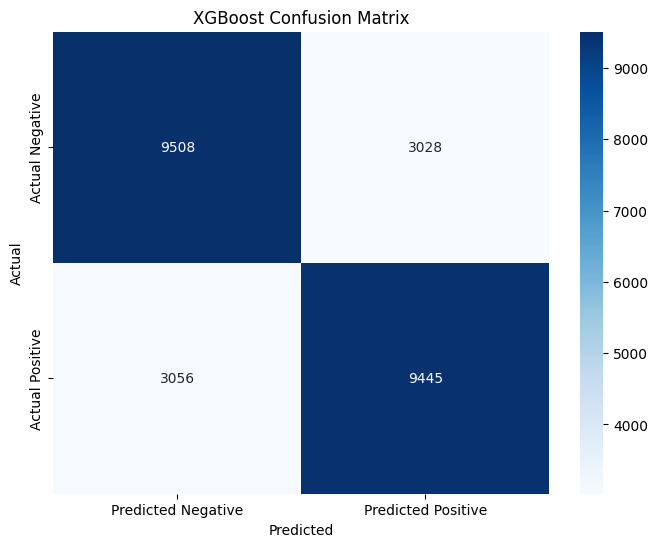

In [54]:
# Train the tuned XGBoost model
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic", eval_metric="logloss",
    subsample=0.875, n_estimators=400, min_child_weight=1, max_depth=3,
    learning_rate=0.1711, colsample_bytree=0.875
)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)
y_pred_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
xgb_brier = brier_score_loss(y_test, y_pred_probs_xgb)
print(f'XGBoost Brier Score: {xgb_brier:.4f}')

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {xgb_accuracy:.4f}')

xgb_logloss = log_loss(y_test, y_pred_probs_xgb)
print(f'XGBoost Log Loss: {xgb_logloss:.4f}')

xgb_auc = roc_auc_score(y_test, y_pred_probs_xgb)
print(f'XGBoost ROC-AUC Score: {xgb_auc:.4f}')

# Calculate and display the confusion matrix
xgb_conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(xgb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

# Suport Vector Machine (SVM) 

In [ ]:
# Train the SVM model
svm_model = SVC(probability=True, kernel='rbf', random_state=57)  # Enable probability estimates
svm_model.fit(X_train_scaled, y_train)

# Get probability predictions
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

# Calculate Brier Score
brier_score_svm = brier_score_loss(y_test, y_pred_proba_svm)
print("Brier Score (SVM with Platt Scaling):", brier_score_svm)
